# Using a Multi-layer perceptron classifier for breast cancer prediction

## Importing the necessary data and cleaning it for our use

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data.csv')
df.drop(['Unnamed: 32'], axis=1 , inplace=True)

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

## Importing the visualization libraries

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

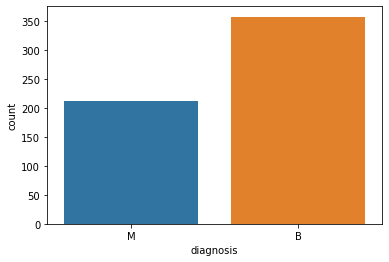

In [6]:
sns.countplot(df.diagnosis);

## Creating dummy target values for GridSearchCV

In [7]:
def dummy(x):
    if x=='M':
        x=1
    if x=='B':
        x=0
    return x

df['diagnosis'] = df['diagnosis'].apply(dummy)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Pre-processing the data using MinMaxScaler for a better comparison of data on a similar scale

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from adspy_shared_utilities import plot_class_regions_for_classifier

X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis']

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Using GridSearchCV to select an optimal value of alpha

### Here we use the scoring parameter as alpha so that the detection majority of tumors which are truely malignant is also predicted to be malignant

### Note that the value of alpha won't be constant. There will be different alpha values on different instances of running the code but it will be within a small range

In [10]:
params = {'alpha': [0.01,0.1,1,3,5,7,10,100,1000]}
clf = MLPClassifier(hidden_layer_sizes = [100,100], solver = 'lbfgs' ,max_iter=1000)

gs = GridSearchCV(clf, param_grid=params, scoring ='recall', cv=20).fit(X_train_scaled, y_train)
print(gs.best_params_)

{'alpha': 3}


In [11]:
bparam = gs.best_params_['alpha']
bscore = gs.best_score_

## Final analysis/report of our machine learning model

In [12]:
print('The best recall score using alpha = {} is {}'.format(bparam, bscore))

The best recall score using alpha = 3 is 0.9535714285714286


In [13]:
clf = MLPClassifier(hidden_layer_sizes = [100,100], solver = 'lbfgs' ,max_iter=1000, alpha = bparam).fit(X_train_scaled, y_train)

In [14]:
print('Classification Report for our MLPClassifier with 2 layers each with 100 hidden units and alpha = {}'.format(bparam))
print('\n', classification_report(y_test, clf.predict(X_test_scaled), target_names=['Benign', 'Malignant']))

Classification Report for our MLPClassifier with 2 layers each with 100 hidden units and alpha = 3

               precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        85
   Malignant       1.00      0.93      0.96        58

    accuracy                           0.97       143
   macro avg       0.98      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



Confusion matrix for our MLPClassifier with 2 layers each with 100 hidden units and alpha = 3

 [[85  0]
 [ 4 54]] 



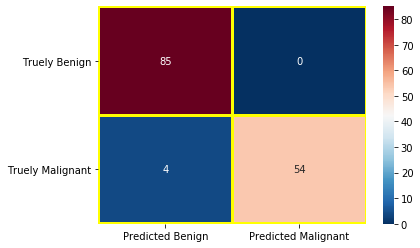

In [15]:
print('Confusion matrix for our MLPClassifier with 2 layers each with 100 hidden units and alpha = {}'.format(bparam))
print('\n', confusion_matrix(y_test, clf.predict(X_test_scaled)), '\n')

fig = plt.figure()
ax = fig.gca()
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test_scaled)), cmap='RdBu_r', annot=True, linewidth = 2, linecolor = 'yellow', xticklabels = ['Predicted Benign', 'Predicted Malignant']);
ax.set_yticklabels(['Truely Benign', 'Truely Malignant'], rotation= 0);

In [29]:
print(f'The model has an accuracy of {clf.score(X_test_scaled, y_test)}')

The model has an accuracy of 0.972027972027972
